In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from modules import io
from modules import vascular_data as sv
from modules.data import get_data

In [2]:
g_cfg_fn   = "../config/global.yaml"
c_cfg_fn   = "../config/rf_ct.yaml"

global_config = io.load_yaml(g_cfg_fn)
case_config   = io.load_yaml(c_cfg_fn)

FILES         = io.read_lines(global_config['FILES'])
print(FILES[:2])

['/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0080/positive/0', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0080/positive/1']


In [3]:
train_pos_list = [i+'.x.npy' for i in FILES if "positive" in i and any([c in i for c in case_config['TRAIN_PATTERNS']])]
train_neg_list = [i+'.x.npy' for i in FILES if "negative" in i and any([c in i for c in case_config['TRAIN_PATTERNS']])]

val_pos_list = [i+'.x.npy' for i in FILES if "positive" in i and any([c in i for c in case_config['VAL_PATTERNS']])]
val_neg_list = [i+'.x.npy' for i in FILES if "negative" in i and any([c in i for c in case_config['VAL_PATTERNS']])]

test_pos_list = [i+'.x.npy' for i in FILES if "positive" in i and any([c in i for c in case_config['TEST_PATTERNS']])]
test_neg_list = [i+'.x.npy' for i in FILES if "negative" in i and any([c in i for c in case_config['TEST_PATTERNS']])]


In [4]:
print(train_pos_list[:5])
print(train_neg_list[:5])

print(len(train_pos_list))
print(len(train_neg_list))

print(len(val_pos_list))
print(len(val_neg_list))

print(len(test_pos_list))
print(len(test_neg_list))

['/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/positive/0.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/positive/1.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/positive/2.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/positive/3.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/positive/4.x.npy']
['/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/negative/0.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/negative/1.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/negative/2.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/negative/3.x.npy', '/media/marsdenlab/Data2/datasets/vessel_tracking/OSMSC0002/negative/4.x.npy']
21068
21543
0
0
3000
3006


In [5]:
N = 3000

data      = get_data(train_pos_list, train_neg_list, N)
test_data = get_data(test_pos_list, test_neg_list, N) 

print(data['X'].shape)
print(data['Y'].shape)

print(test_data['X'].shape)
print(test_data['Y'].shape)

100%|██████████| 3000/3000 [00:01<00:00, 2148.21it/s]


(6000, 16384)
(6000,)
(6000, 16384)
(6000,)


In [6]:
m              = np.mean(data['X'],axis=1)[:,np.newaxis]
s              = np.std(data['X'],axis=1)[:,np.newaxis]+1e-3
data['X_norm'] = (1.0*data['X']-m)/s

m                   = np.mean(test_data['X'],axis=1)[:,np.newaxis]
s                   = np.std(test_data['X'],axis=1)[:,np.newaxis]+1e-3
test_data['X_norm'] = (1.0*test_data['X']-m)/s

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
#model = SGDClassifier(loss="log")

model = RandomForestClassifier(n_estimators=100)

model.fit(data['X_norm'], data['Y'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
test_data['Y_pred'] = model.predict(test_data['X_norm'])

In [9]:
pos_acc = np.mean(test_data['Y_pred'][:N]*test_data['Y'][:N])
neg_acc = np.mean((1-test_data['Y_pred'][N:])*(1-test_data['Y'][N:]))

print("Positive Accuracy: {:.2f}".format(pos_acc))
print("Negative Accuracy: {:.2f}".format(neg_acc))

Positive Accuracy: 0.91
Negative Accuracy: 0.85


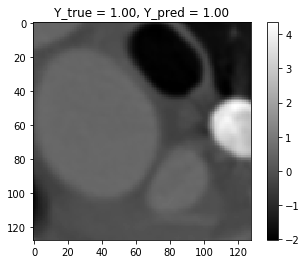

In [21]:
id = np.random.randint(2*N)

true_label = test_data['Y'][id]
pred_label = test_data['Y_pred'][id]
x          = test_data['X_norm'][id].reshape((128,128))

plt.figure()
plt.title("Y_true = {:.2f}, Y_pred = {:.2f}".format(true_label, pred_label))
plt.imshow(x, cmap='gray')
plt.colorbar()
plt.show()